# Диагностика сердечно сосудестых заболеваний check

Цель данного исследования на основе данных о пациенте предположить у него ССЗ.

## Описание даных

### Файлы

Даны три файла:
- sample_submission.csv - образец выходных данных
- test.csv - выборка для получения финальных результатов
- train.csv - выборка для тренировки модели

### Столбцы

0. id - уникальный id пациента
1. age - возраст пациента
2. gender - пол
3. height - рост 
4. weight - вес 
5. ap_hi - верхнее давление 
6. ap_lo - ниэнее дваление
7. cholesterol - уровень халестерина
8. gluc - 
9. smoke - курящий 
10. alco - алкоголик
11. active - активный образ жизни
12. cardio - ССЗ

## Выгрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
from notifiers import get_notifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

In [2]:
STATE = 46587

Для будущего обучения моделей и получения уведоблений о завершении работы, напишем функцию.

In [3]:
def make_notifier(
    token='-',
    chat_id=-):
    def f(text):
        notifier = get_notifier('telegram')
        notifier.notify(
            message=text,
            token=token,
            chat_id=chat_id)
    return f

bot_send = make_notifier()

In [113]:
train = pd.read_csv('./train.csv')

In [114]:
test = pd.read_csv('./test.csv')

In [7]:
train.sample(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
12678,18100,14308,1,166,44.0,90,60,1,1,0,0,1,0
35060,50088,19197,1,158,59.0,120,80,1,1,0,0,1,1
10757,15383,14599,2,167,79.0,110,70,1,1,1,0,0,0
18422,26303,16010,1,157,73.0,120,80,2,1,0,0,1,1
39184,55951,19859,1,180,87.0,110,70,2,2,0,0,0,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [9]:
test.sample(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
23042,77068,21934,1,156,54.0,120,80,1,3,0,0,1
11853,39442,19054,1,160,72.0,140,90,1,2,0,0,1
29544,98464,20354,1,164,66.0,120,80,1,1,0,0,1
24909,83242,20581,2,172,84.0,140,90,1,1,0,0,0
20936,69879,17466,2,168,63.0,140,90,1,1,0,0,1


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


Проверяем на дубликаты, со столбцом `id` и без, для оценк.

In [11]:
train.duplicated().sum()

0

In [12]:
train.drop(['id'],axis=1).duplicated().sum()

24

In [13]:
test.duplicated().sum()

0

In [14]:
test.drop(['id'],axis=1).duplicated().sum()

6

Явных дубликатов нет, а дубликаты без столбца `id` всего 24. Это нормально, что для 70к человек у 24 показатели одинаковые, а для тестовой всего 6 на 30к.

Теперь нужно посмотреть все ли `id` разные.

In [15]:
len(train['id'].unique())

70000

In [16]:
len(test['id'].unique())

30000

Значение в стобце `age` приставлено в днях. Для удобства можно добавить столбец с возрастом в годах, для лучшей визуальной оценки.

In [17]:
train['age_y'] = train['age'] // 365

Все здорово. Можно идти дальше.

 ## Распределение данных.

Для корректного обучения модели нужно оценить как распределены данные в тренировочной и тестовой выборках.

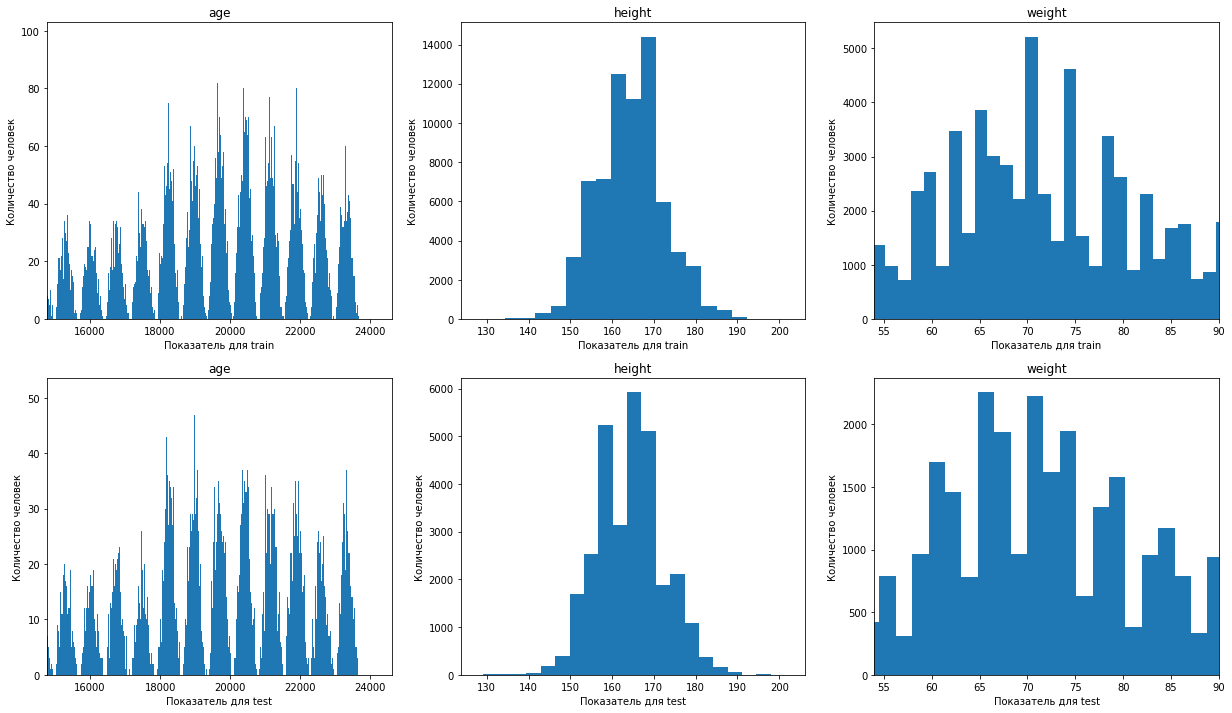

In [18]:
i = 1
fig = plt.figure(figsize=(21, 12))
for df in [train,test]:
    for column in ['age','height','weight']:
        fig.add_subplot(2,3,i).hist(df[column], bins=int(len(df[column].unique())*.5))
        if i < 4: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Количество человек")
        plt.title(f"{column}")
        plt.xlim(df[column].median()*0.75,df[column].median()*1.25)
        i += 1

Как видно из графиков, распределения возрастов, весов и роста похожи. Теперь можно посмотреть на остальные столбцы.

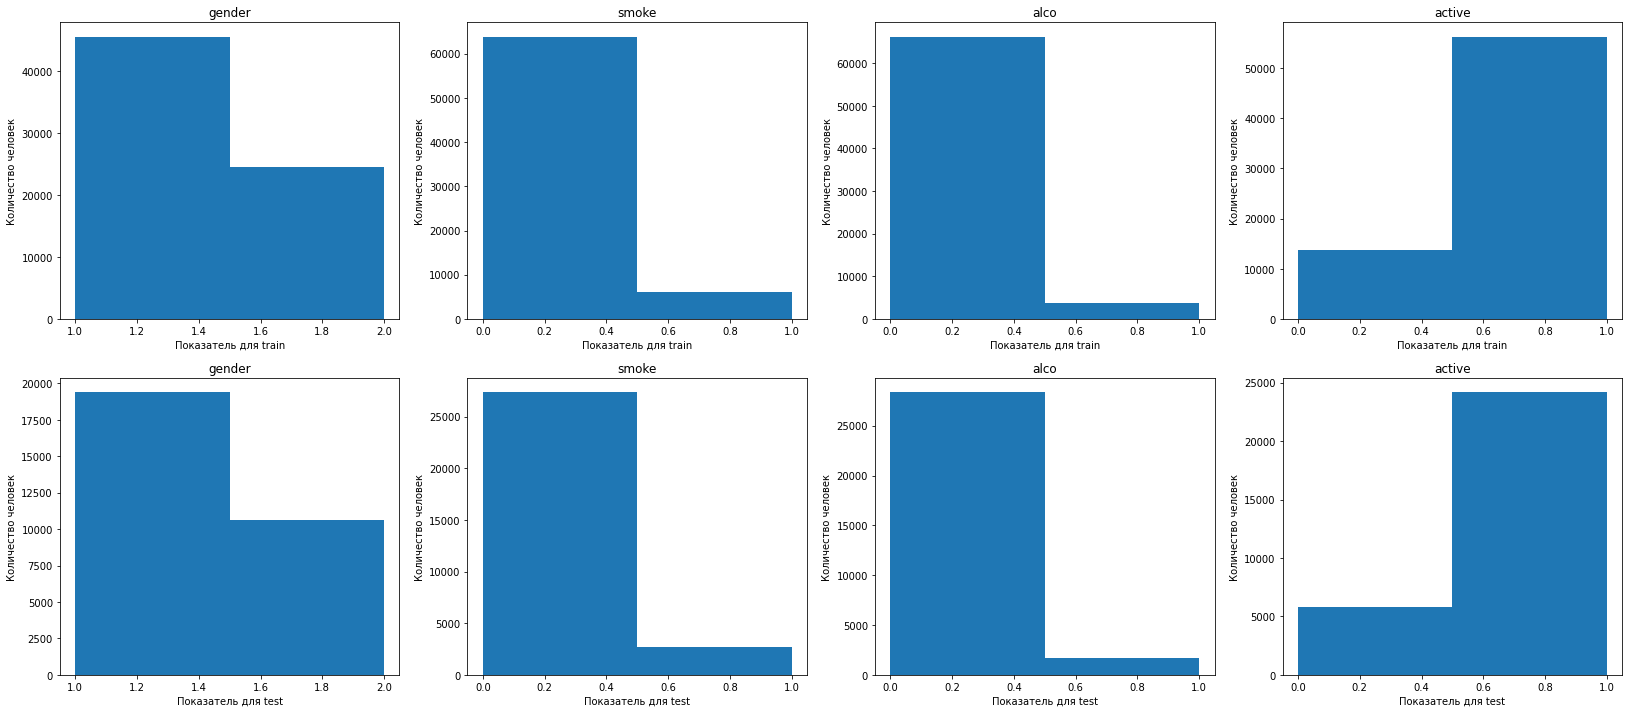

In [19]:
i = 1
fig = plt.figure(figsize=(28, 12))
for df in [train,test]:
    for column in ['gender','smoke','alco','active']:
        fig.add_subplot(2,4,i).hist(df[column],bins = 2)
        if i < 5: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Количество человек")
        plt.title(f"{column}")
        i += 1

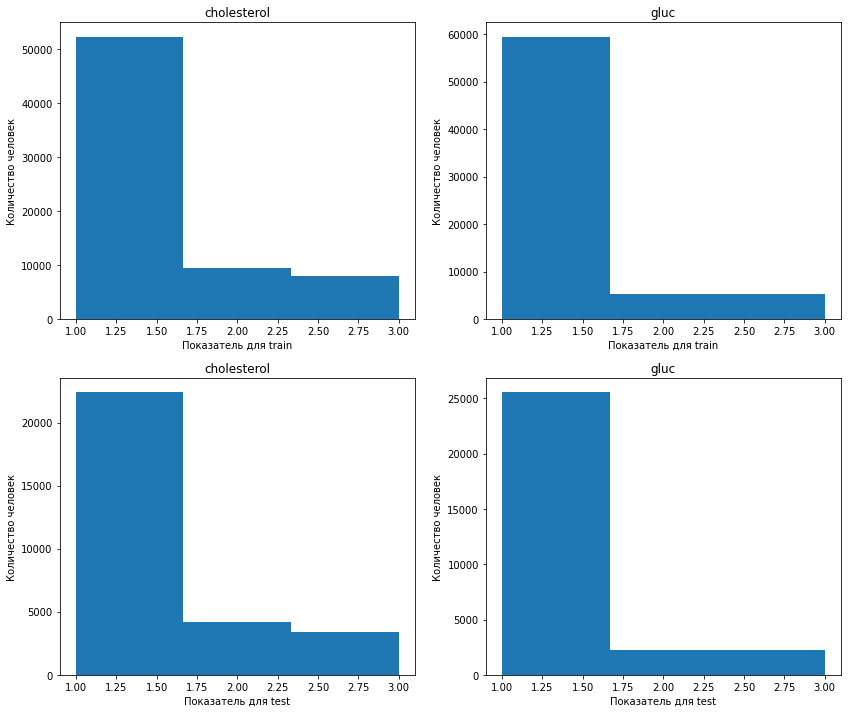

In [20]:
i = 1
fig = plt.figure(figsize=(14, 12))
for df in [train,test]:
    for column in ['cholesterol','gluc']:
        fig.add_subplot(2,2,i).hist(df[column],bins = 3)
        if i < 3: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Количество человек")
        plt.title(f"{column}")
        i += 1

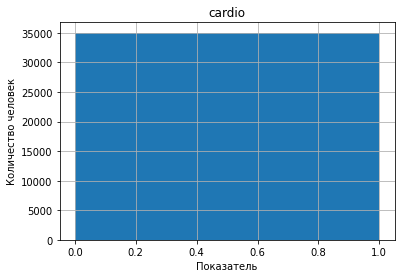

In [21]:
plt.xlabel("Показатель")
plt.ylabel("Количество человек")
plt.title("cardio")
train['cardio'].hist(bins = 2)
plt.show()

Нет дисбаланса в стобце `cardio` это хорошо.

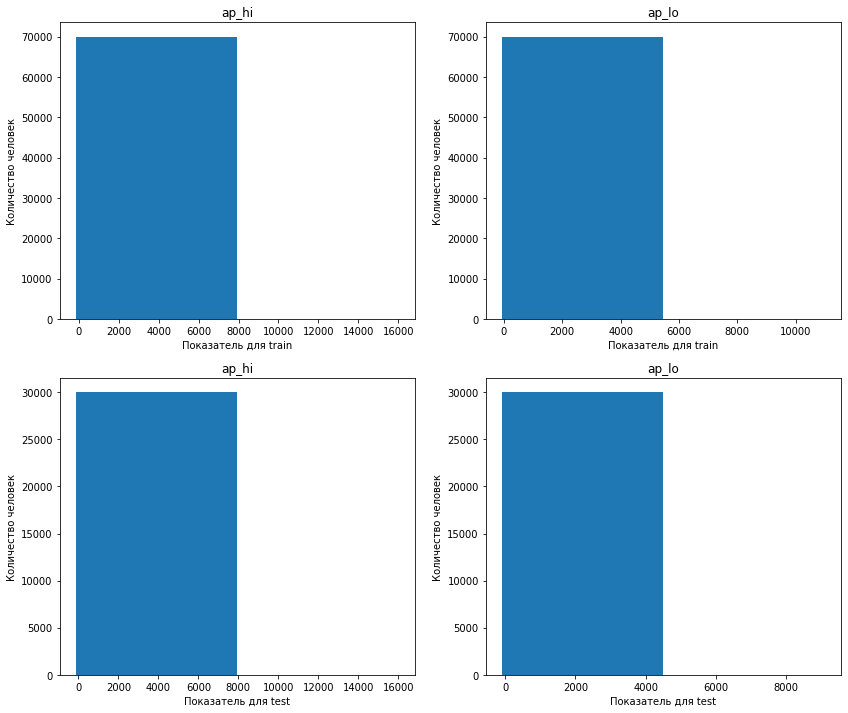

In [22]:
i = 1
fig = plt.figure(figsize=(14, 12))
for df in [train,test]:
    for column in ['ap_hi','ap_lo']:
        fig.add_subplot(2,2,i).hist(df[column],bins = 2)
        if i < 3: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Количество человек")
        plt.title(f"{column}")
        i += 1

Как видно из графиков, все распределенияв выборках очень похожи, но есть некоторые аномалии в столбцах `ap_hi` и `ap_lo`. Нужно с ними разобраться.

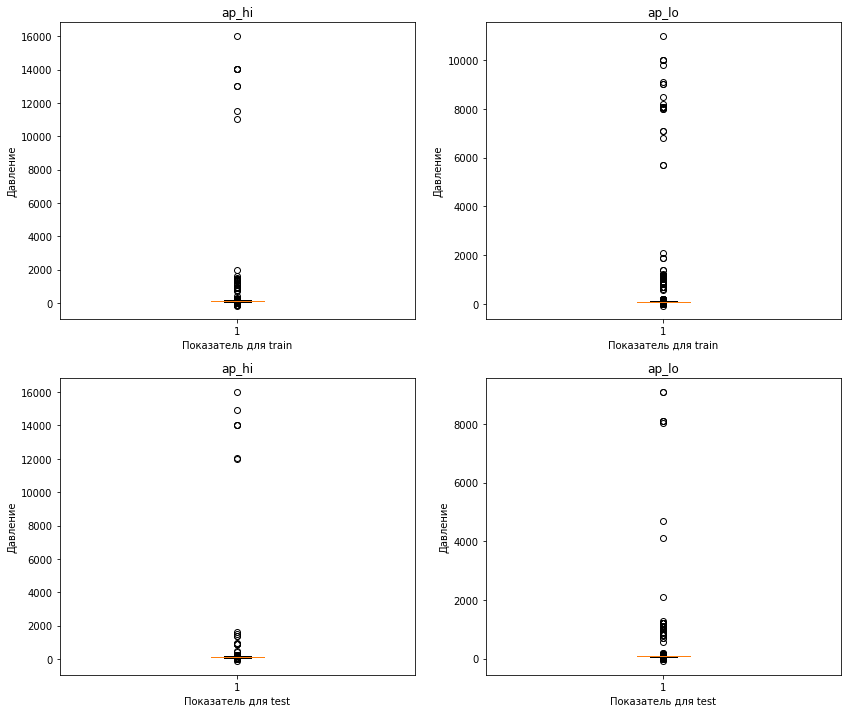

In [23]:
i = 1
fig = plt.figure(figsize=(14, 12))
for df in [train,test]:
    for column in ['ap_hi','ap_lo']:
        fig.add_subplot(2,2,i).boxplot(df[column])
        if i < 3: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Давление")
        plt.title(f"{column}")
        i += 1

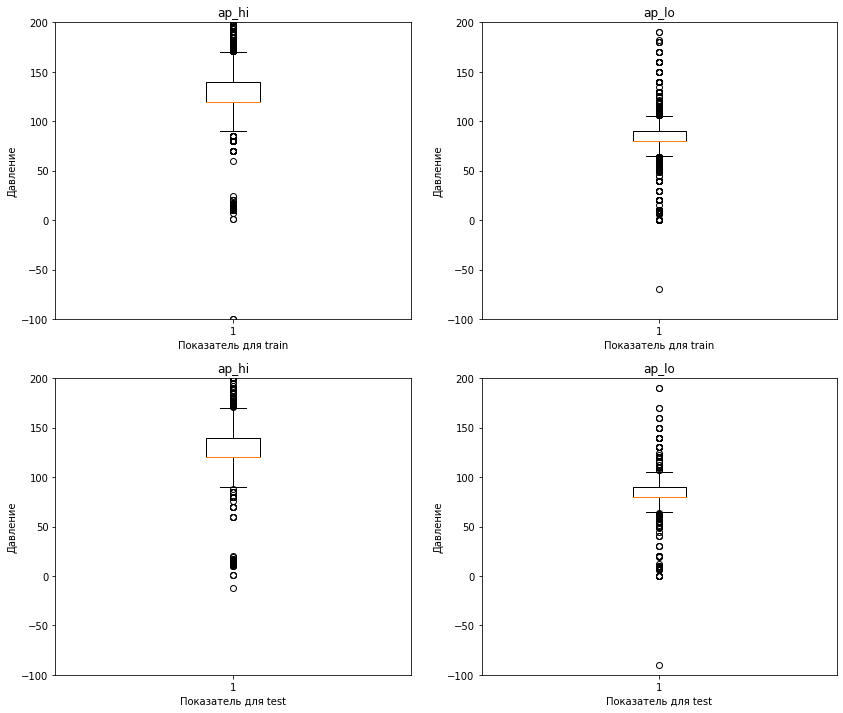

In [24]:
i = 1
fig = plt.figure(figsize=(14, 12))
for df in [train,test]:
    for column in ['ap_hi','ap_lo']:
        fig.add_subplot(2,2,i).boxplot(df[column])
        if i < 3: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Давление")
        plt.ylim(-100,200)
        plt.title(f"{column}")
        i += 1

Как видно из "коробок с усами" в данных столбцах есть выбросы, причем даже в отрицательную сторону нужно изучить их.

Видно что некоторая часть выбросо выходит за значение 10.000 возможно это по ошибки два давления нзаписали в одну ячейку.

In [25]:
train.loc[train['ap_hi'] > 10000, ['ap_hi','ap_lo']]

,ap_hi,ap_lo
7763,11500,90
25464,14020,80
25519,14020,80
40852,16020,80
46912,14020,90
47253,14020,90
51438,11020,80
55459,13010,80
55847,13010,80


In [26]:
test.loc[test['ap_hi'] > 10000, ['ap_hi','ap_lo']]

,ap_hi,ap_lo
5176,12008,80
7755,14020,90
8852,16020,70
9399,14020,90
13563,14020,80
14449,14900,90
24391,12080,80


Предположение не оправдалось, так как нижнее дваление в норме, а высокое давление не нормально, можно предположить, что высокое замерялось с большей точностью и просто не указали точку в значении. 

In [27]:
(train.loc[train['ap_lo'] > 1000, ['ap_hi','ap_lo']])

,ap_hi,ap_lo
228,160,1100
473,150,1033
649,190,1100
881,150,1100
1033,150,1001
...,...,...
67474,160,1200
68037,170,1100
68288,180,1100
68538,160,10000


In [28]:
test.loc[test['ap_lo'] > 1000, ['ap_hi','ap_lo']]

,ap_hi,ap_lo
644,160,1110
1707,220,1130
1929,1,1099
2647,160,1200
3160,170,4100
...,...,...
29181,190,1100
29396,140,1100
29468,170,1100
29720,200,1100


In [29]:
train['ap_hi'].describe()

count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [30]:
train['ap_lo'].describe()

count    70000.000000
mean        96.630414
std        188.472530
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

In [31]:
test['ap_hi'].describe()

count    30000.000000
mean       130.271300
std        212.501152
min       -130.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [32]:
test['ap_lo'].describe()

count    30000.000000
mean        95.689000
std        163.852598
min        -90.000000
25%         80.000000
50%         80.000000
75%         90.000000
max       9100.000000
Name: ap_lo, dtype: float64

Есть несколько способов решить данную проблему:
1. Просто удалить выбросы которые не попадают во второй и третий квартиль. Этот вариант не подходит по скольку тогда останутся люди с хорошим давлением и на них ничему не обучишься.
2. Удалить только 5% выбросов. Отсортировать данные и убрать по 1750 строк сверху и снизу. Тоже не самое лучшее решение, его можно применить в случае если не получится третий способ.
3. Ручками оценить значения выбросов и понять какая у них есть закономерность.

## Работа с выбросами

### Давление

Для дальнешей работы с выбросами нужно посмотреть на них и оценить.

Все выбросы которые ниже нуля можно перевсти в положительные значения, возмонжно это была просто ошибка. Верхнее давление которе больше 10000 скорее всего записано как верхнее и нижнее, а значения больше 300 можно выкинуть, их не так много. С нижним давлением молжно поступить также.

In [33]:
train.loc[train['ap_hi'] < 0, 'ap_hi'] = train.loc[train['ap_hi'] < 0, 'ap_hi']*(-1)

In [34]:
train.loc[train['ap_hi'] < 0, 'ap_hi']

Series([], Name: ap_hi, dtype: int64)

In [35]:
train.loc[train['ap_lo'] < 0, 'ap_lo'] = train.loc[train['ap_lo'] < 0, 'ap_lo']*(-1)

In [36]:
train.loc[train['ap_lo'] < 0, 'ap_lo']

Series([], Name: ap_lo, dtype: int64)

In [37]:
test.loc[test['ap_lo'] < 0, 'ap_lo'] = test.loc[test['ap_lo'] < 0, 'ap_lo']*(-1)
test.loc[test['ap_hi'] < 0, 'ap_hi'] = test.loc[test['ap_hi'] < 0, 'ap_hi']*(-1)

In [38]:
test.loc[test['ap_hi'] > 10000, 'ap_hi'] = test.loc[test['ap_hi'] > 10000, 'ap_hi'] // 100
test.loc[test['ap_lo'] > 1000, 'ap_lo'] = test.loc[test['ap_lo'] > 1000, 'ap_lo'] // 100

In [39]:
train.loc[train['ap_hi'] > 10000, 'ap_hi'] = train.loc[train['ap_hi'] > 10000, 'ap_hi'] // 100

In [40]:
train.loc[train['ap_lo'] > 1000, 'ap_lo'] = train.loc[train['ap_lo'] > 1000, 'ap_lo'] // 100

In [41]:
train.loc[train['ap_lo'] > 1000, 'ap_lo']

Series([], Name: ap_lo, dtype: int64)

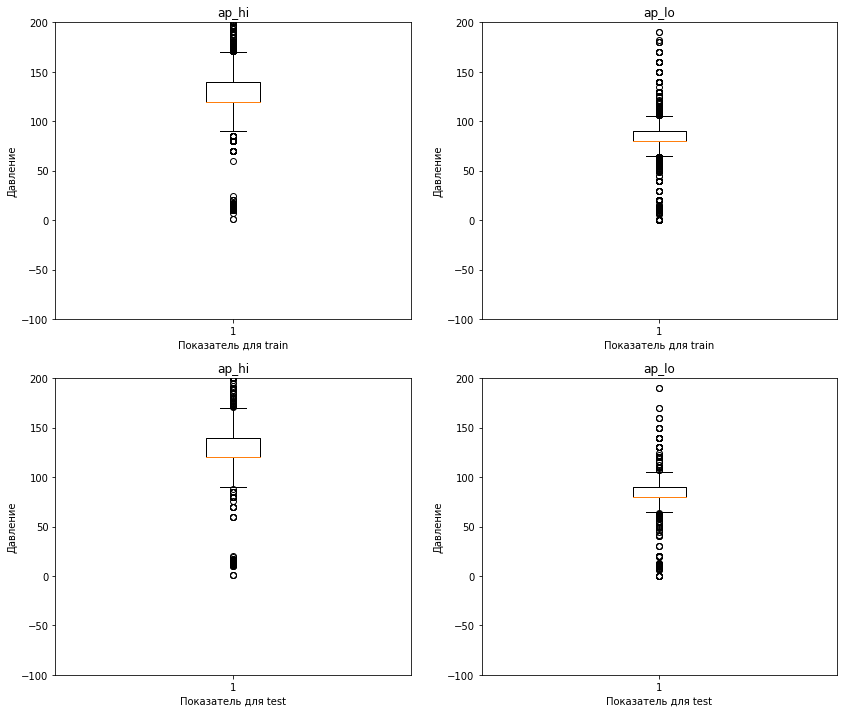

In [42]:
i = 1
fig = plt.figure(figsize=(14, 12))
for df in [train,test]:
    for column in ['ap_hi','ap_lo']:
        fig.add_subplot(2,2,i).boxplot(df[column])
        if i < 3: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Давление")
        plt.ylim(-100,200)
        plt.title(f"{column}")
        i += 1

In [43]:
train['ap_hi'].describe()

count    70000.000000
mean       127.135214
std         28.170638
min          1.000000
25%        120.000000
50%        120.000000
75%        140.000000
max       2000.000000
Name: ap_hi, dtype: float64

In [44]:
train['ap_lo'].describe()

count    70000.000000
mean        90.160986
std         91.112515
min          0.000000
25%         80.000000
50%         80.000000
75%         90.000000
max       1000.000000
Name: ap_lo, dtype: float64

In [45]:
len(train.loc[train['ap_hi'] > 300, 'ap_hi'])

31

In [46]:
len(train.loc[train['ap_lo'] > 210, 'ap_lo'])

698

Уже стало лучше, в принцрипе потеря 700 строк не так критична, это всего 1% информации. По этому удаляем строки.

In [47]:
train = train.drop(index = train.loc[train['ap_hi']>300, 'ap_hi'].index)

In [48]:
train = train.drop(index = train.loc[train['ap_lo'] > 210, 'ap_lo'].index)

In [49]:
len(train)

69271

In [50]:
train.sample(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_y
15259,21809,19531,1,160,64.0,140,90,3,1,0,0,1,1,53
36469,52094,15832,1,167,45.0,90,65,1,1,0,0,1,0,43
62962,89920,23323,1,150,69.0,130,80,3,3,0,0,1,1,63
25200,35974,21081,1,165,60.0,120,70,3,1,0,0,1,1,57
5398,7674,16069,2,167,69.0,120,80,1,1,0,0,0,0,44


Отлично, теперь идем к другим параметрам.

### Вес и рост

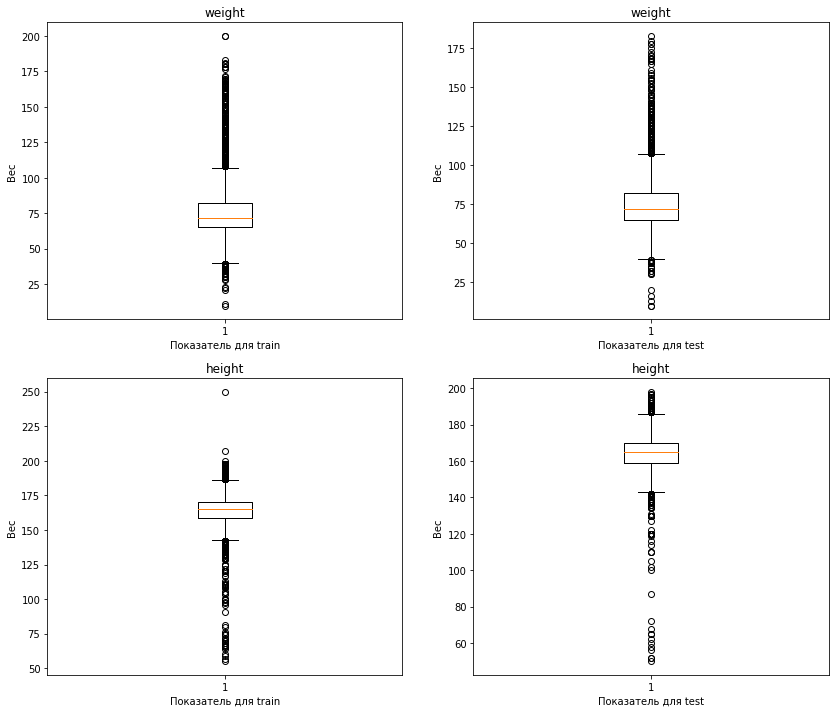

In [51]:
i = 1
fig = plt.figure(figsize=(14, 12))
for column in ['weight', 'height']:
    for df in [train,test]:
        fig.add_subplot(2,2,i).boxplot(df[column])
        if i%2 == 1: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Вес")
        plt.title(f"{column}")
        i += 1

In [52]:
i = 1
for df in [train,test]:
    if i == 1: print('train')
    else: print('test')
    i += 1
    for column in ['weight', 'height']:
        print(column)
        display(df[column].describe())


train
weight


count    69271.000000
mean        74.148710
std         14.355692
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

height


count    69271.000000
mean       164.359241
std          8.204833
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

test
weight


count    30000.000000
mean        74.120615
std         14.341540
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        183.000000
Name: weight, dtype: float64

height


count    30000.000000
mean       164.322267
std          8.213740
min         50.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        198.000000
Name: height, dtype: float64

Согласно статистики средний рост чаловека 160см, а вес 70кг. По скольку наши средние значения почти идеально в них попадают можно предположить, что тут используются тежи единицы измерения.

Оценим выбросы по нижней границе, посмотрим на вес меньше 40кг и рост ниже 120см. Полностью убирать выбросы нельзя, по скольку если оставить нормальные значения, то скорее всего останутся здоровые люди и модель не сможет нормально обучится.

In [53]:
train.loc[train['weight'] < 40, ['weight','age_y','height']]

,weight,age_y,height
3752,30.00,42,120
5794,37.00,48,151
10447,38.00,60,162
10627,37.00,59,153
11876,39.00,47,157
14722,34.00,62,143
16322,35.00,59,165
16906,31.00,47,170
18559,30.00,49,160
19582,38.00,58,152


Очень сомневаюсь, что люди в возрасте 50 лет весят меньши 30кг. По этому значения меньше 30 можно выбросить как не ошибочные. Люди от 30-40кг бывают в этой жизни, их оставим.

In [54]:
train = train.drop(index = train.loc[train['weight'] < 30, 'weight'].index)
train.loc[train['weight'] < 40, ['weight','age_y','height']]


,weight,age_y,height
3752,30.00,42,120
5794,37.00,48,151
10447,38.00,60,162
10627,37.00,59,153
11876,39.00,47,157
14722,34.00,62,143
16322,35.00,59,165
16906,31.00,47,170
18559,30.00,49,160
19582,38.00,58,152


Теперь рост.

In [55]:
train.loc[train['height'] < 120, ['weight','height','age_y']]

,weight,height,age_y
224,55.0,76,59
3420,70.0,100,39
7116,78.0,117,56
7598,72.0,70,40
8171,170.0,97,48
8677,89.0,119,53
11230,90.0,110,50
12770,168.0,75,53
13265,68.0,71,61
14323,57.0,67,60


Для лучшей оценки можно добавить столбец `BMI` индекс массы тела.

In [56]:
train['BMI'] = train['weight'] / (train['height']/100)**2


In [57]:
test['BMI'] = test['weight'] / (test['height']/100)**2

In [58]:
train.loc[train['height'] < 120, ['weight','height','BMI','age_y']]

,weight,height,BMI,age_y
224,55.0,76,95.221607,59
3420,70.0,100,70.000000,39
7116,78.0,117,56.980057,56
7598,72.0,70,146.938776,40
8171,170.0,97,180.678074,48
8677,89.0,119,62.848669,53
11230,90.0,110,74.380165,50
12770,168.0,75,298.666667,53
13265,68.0,71,134.893870,61
14323,57.0,67,126.977055,60


Все значения `BMI` которые выходят за 40 единиц считаются ожирением 3 степени, добавим еще 20 к ним, по скольку формула расчитына на обычного человека, тут мы не все знаем про людей, следовательно все у кого `BMI` выше 60 удаляем.

In [59]:
train.loc[(train['BMI'] > 70), ['height','weight','BMI']]

,height,weight,BMI
224,76,55.0,95.221607
6153,122,161.0,108.169847
7598,70,72.0,146.938776
8171,97,170.0,180.678074
11230,110,90.0,74.380165
12435,137,161.0,85.779743
12770,75,168.0,298.666667
13265,71,68.0,134.893870
14323,67,57.0,126.977055
15167,70,68.0,138.775510


In [60]:
train = train.drop(index = train.loc[train['BMI'] > 60].index)

In [61]:
train.loc[train['height'] < 120, ['weight','height','BMI','age_y']]

,weight,height,BMI,age_y
7116,78.0,117,56.980057,56
17277,45.0,98,46.855477,48
29735,64.0,109,53.867520,47
34364,70.0,110,57.851240,59
41807,68.0,109,57.234240,63
45091,70.0,110,57.851240,49
46043,69.0,111,56.001948,51
50136,73.0,113,57.169708,64
58868,60.0,100,60.000000,40
59738,68.0,110,56.198347,46


Теперь верхняя граница, в нашей жизни люди выше 2м встречаются, самый высокий человек был выше 2.5м. По этому возьмем что-то среднее. Посмторим на поциентов выше 2.25м.

In [62]:
train.loc[train['height'] > 225, ['weight','height','BMI','age_y']]

,weight,height,BMI,age_y
6486,86.0,250,13.76,58


Он всего один, думаю он не обидется если его не будет в финальной таблице.

In [63]:
train = train.drop(index = train.loc[train['height'] > 225, 'height'].index)

На счет веса, максимальное значение в нашей таблице это 200кг, много но ничего сверх естественного.

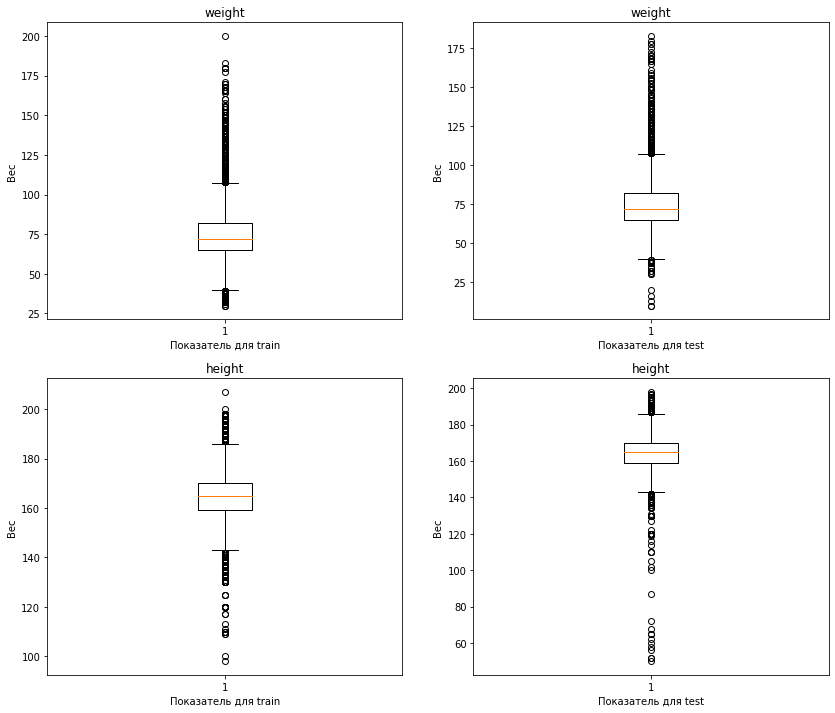

In [64]:
i = 1
fig = plt.figure(figsize=(14, 12))
for column in ['weight', 'height']:
    for df in [train,test]:
        fig.add_subplot(2,2,i).boxplot(df[column])
        if i%2 == 1: plt.xlabel("Показатель для train")
        else: plt.xlabel("Показатель для test")
        plt.ylabel("Вес")
        plt.title(f"{column}")
        i += 1

Стало немного лучше.

Для большей наглдности можно еще посмотреть на коробку `BMI`.

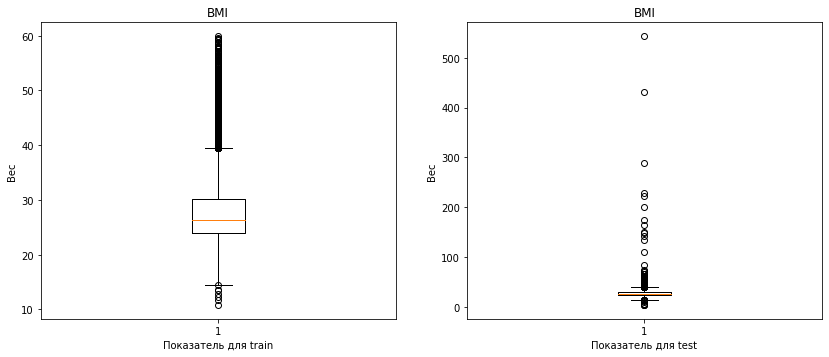

In [65]:
i = 1
fig = plt.figure(figsize=(14, 12))
for df in [train,test]:
    fig.add_subplot(2,2,i).boxplot(df['BMI'])
    if i%2 == 1: plt.xlabel("Показатель для train")
    else: plt.xlabel("Показатель для test")
    plt.ylabel("Вес")
    plt.title(f"{'BMI'}")
    i += 1

Получилось как специально, 2ой и 3ий квартиль `BMI` для тренировочной выборки лежат в диапозонах классификации ожирения. Если посмотреть на тестовую то разница с тренировочной огромная.

Теперь можно добавить категории для столбца `BMI`, кажется что это поможет моделе.

Для этого нужно создать несколько столбцйов в таблице 

In [66]:
train[['BMI_low','BMI_norm','BMI_hi','BMI_1','BMI_2','BMI_3']] = 0
test[['BMI_low','BMI_norm','BMI_hi','BMI_1','BMI_2','BMI_3']] = 0

In [67]:
train.loc[train['BMI'] < 18.5, 'BMI_low'] = 1
test.loc[test['BMI'] < 18.5, 'BMI_low'] = 1

train.loc[(train['BMI'] >= 18.5) & (train["BMI"] < 25), 'BMI_norm'] = 1
test.loc[(test['BMI'] >= 18.5) & (test["BMI"] < 25), 'BMI_norm'] = 1

train.loc[(train['BMI'] >= 25) & (train["BMI"] < 30), 'BMI_hi'] = 1
test.loc[(test['BMI'] >= 25) & (test["BMI"] < 30), 'BMI_hi'] = 1

train.loc[(train['BMI'] >= 30) & (train["BMI"] < 35), 'BMI_1'] = 1
test.loc[(test['BMI'] >= 30) & (test["BMI"] < 35), 'BMI_1'] = 1

train.loc[(train['BMI'] >= 35) & (train["BMI"] < 40), 'BMI_2'] = 1
test.loc[(test['BMI'] >= 35) & (test["BMI"] < 40), 'BMI_2'] = 1

train.loc[train['BMI'] >= 40, 'BMI_3'] = 1
test.loc[test['BMI'] >= 40, 'BMI_3'] = 1

In [68]:
train.sample()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,active,cardio,age_y,BMI,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3
35449,50633,21962,2,170,64.0,150,110,1,1,0,...,1,1,60,22.145329,0,1,0,0,0,0


### Вывод

Тренировочная выборка подготовлена для дальнейшей работы. Тестовую не трогали по сольку данные в модель могут поступать любые и нужно оценить как она с ними справится.

## Подготовка к обучению

Для дальнейшего обучения, необходимо поготовить данные. Во первых если нужно закодировать, какие-то столбцы и привести все к одному масштабу.

Посмотрим для начла на столбец `gender`. Какжтся что для лучего усвоения моделью, нужно его перевести на столбец `men`

По скольку в описании нет объяснения кто есть кто, посмотрим на распределение данных, по логике мужчины должны быть выше и больше весить.

In [69]:
train.loc[train['gender'] == 1, 'weight'].describe()

count    45054.000000
mean        72.470333
std         14.048954
min         30.000000
25%         63.000000
50%         70.000000
75%         80.000000
max        200.000000
Name: weight, dtype: float64

In [70]:
train.loc[train['gender'] == 2, 'weight'].describe()

count    24145.000000
mean        77.190404
std         14.054681
min         31.000000
25%         68.000000
50%         75.000000
75%         85.000000
max        183.000000
Name: weight, dtype: float64

In [71]:
train.loc[train['gender'] == 1, 'height'].describe()

count    45054.000000
mean       161.416833
std          6.751066
min         98.000000
25%        157.000000
50%        162.000000
75%        166.000000
max        198.000000
Name: height, dtype: float64

In [72]:
train.loc[train['gender'] == 2, 'height'].describe()

count    24145.000000
mean       169.993829
std          6.912325
min        100.000000
25%        165.000000
50%        170.000000
75%        175.000000
max        207.000000
Name: height, dtype: float64

Как видно, строки со значением 2 в столбце `gender` и выше и больше, значит, скорее всего, это мужчины.  
Основываясь на этих данных создадим столбец `men`.

In [73]:
train['men'] = 0
train.loc[train['gender'] == 2, 'men'] = 1

In [74]:
test['men'] = 0
test.loc[test['gender'] == 2, 'men'] = 1

In [75]:
train.sample(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,cardio,age_y,BMI,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
2612,3683,23445,1,170,64.0,10,70,1,1,0,...,1,64,22.145329,0,1,0,0,0,0,0
43954,62803,20972,2,176,88.0,120,80,1,1,0,...,1,57,28.409091,0,0,1,0,0,0,1
22071,31526,20223,1,163,92.0,140,90,2,1,0,...,1,55,34.626821,0,0,0,1,0,0,0
8178,11670,21695,2,169,92.0,160,80,1,1,0,...,1,59,32.211757,0,0,0,1,0,0,1
45604,65149,15205,1,160,66.0,140,80,1,1,0,...,1,41,25.781250,0,0,1,0,0,0,0


In [76]:
test.sample(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
3807,12750,20487,1,198,80.0,120,80,3,3,0,0,0,20.406081,0,1,0,0,0,0,0
11688,38876,21097,2,165,85.0,120,80,1,1,1,0,1,31.221304,0,0,0,1,0,0,1
16305,54469,23344,1,164,66.0,135,85,2,1,0,0,1,24.538965,0,1,0,0,0,0,0
19075,63617,15844,2,164,64.0,120,80,1,1,0,0,1,23.795360,0,1,0,0,0,0,1
28980,96699,19763,1,170,112.0,160,100,1,1,0,0,1,38.754325,0,0,0,0,1,0,0


По скольку столбце `gender` дублирует информацию `men` то его можно убрать.

In [77]:
train = train.drop(['gender'],axis=1)


In [78]:
test = test.drop(['gender'],axis=1)

In [79]:
train.sample(5)

,id,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,cardio,age_y,BMI,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
43251,61787,17471,165,61.0,140,90,1,1,0,0,...,1,47,22.405877,0,1,0,0,0,0,1
58429,83378,18236,170,89.0,120,80,1,1,0,0,...,0,49,30.795848,0,0,0,1,0,0,1
54928,78363,18463,174,74.0,120,80,1,1,0,0,...,0,50,24.441802,0,1,0,0,0,0,1
69343,99049,21718,156,72.0,140,80,3,1,0,0,...,1,59,29.585799,0,0,1,0,0,0,0
51148,72960,20404,158,63.0,120,80,1,1,0,0,...,0,55,25.236340,0,0,1,0,0,0,1


In [80]:
train = pd.merge(left=train,
                right= pd.get_dummies(train['cholesterol']),
                left_index=True,
                right_index=True)


"train = pd.merge(left=train,\n                right= pd.get_dummies(train['cholesterol']),\n                left_index=True,\n                right_index=True)"

In [81]:
train = train.rename(columns={1: 'cholesterol_1',
                              2: 'cholesterol_2',
                              3:'cholesterol_3'})

"train = train.rename(columns={1: 'cholesterol_1',\n                              2: 'cholesterol_2',\n                              3:'cholesterol_3'})"

In [82]:
train = pd.merge(left=train,
                right= pd.get_dummies(train['gluc']),
                left_index=True,
                right_index=True)

"train = pd.merge(left=train,\n                right= pd.get_dummies(train['gluc']),\n                left_index=True,\n                right_index=True)"

In [83]:
train = train.rename(columns={1: 'gluc_1',
                              2: 'gluc_2',
                              3:'gluc_3'})

"train = train.rename(columns={1: 'gluc_1',\n                              2: 'gluc_2',\n                              3:'gluc_3'})"

In [84]:
train = train.drop(['gluc', 'cholesterol'],axis=1)

"train = train.drop(['gluc', 'cholesterol'],axis=1)"

In [85]:
test = pd.merge(left=test,
                right= pd.get_dummies(test['cholesterol']),
                left_index=True,
                right_index=True)
test = test.rename(columns={1: 'cholesterol_1',
                              2: 'cholesterol_2',
                              3:'cholesterol_3'})
test = pd.merge(left=test,
                right= pd.get_dummies(test['gluc']),
                left_index=True,
                right_index=True)
test = test.rename(columns={1: 'gluc_1',
                              2: 'gluc_2',
                              3:'gluc_3'})

"test = pd.merge(left=test,\n                right= pd.get_dummies(test['cholesterol']),\n                left_index=True,\n                right_index=True)\ntest = test.rename(columns={1: 'cholesterol_1',\n                              2: 'cholesterol_2',\n                              3:'cholesterol_3'})\ntest = pd.merge(left=test,\n                right= pd.get_dummies(test['gluc']),\n                left_index=True,\n                right_index=True)\ntest = test.rename(columns={1: 'gluc_1',\n                              2: 'gluc_2',\n                              3:'gluc_3'})"

In [86]:
test = test.drop(['gluc', 'cholesterol'],axis=1)

"test = test.drop(['gluc', 'cholesterol'],axis=1)"

Кажется что больше ни с чем сильно не покалдуешь. По этому будем приводить все к олному масштабу. Но с начала разделим выорку на фичи и ответы.

Для фичей нам точно не понадобится столбце `id` и `age_y`, второй мы создавали для себя и наглядности. Так же не нужен столбце `BMI`, по сокльку есть категории.

In [115]:
train = train.drop(['id','age_y','BMI'],axis=1)

In [116]:
test = test.drop(['id','BMI'],axis=1)

In [89]:
train.sample(5)

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
9152,22022,159,75.0,120,80,1,1,0,0,1,1,0,0,1,0,0,0,0
14200,19776,160,55.0,120,80,3,3,0,0,1,1,0,1,0,0,0,0,0
22807,23158,163,72.0,130,80,1,1,0,0,1,0,0,0,1,0,0,0,0
49639,22613,185,92.0,130,80,1,1,1,0,1,0,0,0,1,0,0,0,1
65587,21881,160,66.0,120,80,1,1,0,0,1,0,0,0,1,0,0,0,0


In [90]:
test.sample(5)

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
24675,16157,176,81.0,120,80,1,1,0,0,0,0,0,1,0,0,0,0
3365,21164,165,69.0,130,70,1,1,0,0,1,0,0,1,0,0,0,1
23513,22475,157,90.0,150,90,1,1,0,0,0,0,0,0,0,1,0,0
14688,15875,168,95.0,130,80,1,1,0,0,0,0,0,0,1,0,0,0
13196,20350,166,59.0,140,60,3,3,0,0,0,0,1,0,0,0,0,1


In [91]:
train.sample(5)

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
43410,19721,175,77.0,140,90,1,1,0,0,1,1,0,0,1,0,0,0,1
842,14890,165,60.0,120,80,1,1,0,0,0,0,0,1,0,0,0,0,1
68935,21117,164,75.0,130,90,1,1,0,0,0,1,0,0,1,0,0,0,1
6235,21692,159,68.0,120,79,1,1,0,0,1,0,0,0,1,0,0,0,0
22344,18307,152,56.0,120,70,3,1,0,0,1,0,0,1,0,0,0,0,0


In [92]:
test.sample(5)

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
25085,19815,165,60.0,120,80,1,1,0,0,1,0,1,0,0,0,0,1
21739,19096,168,76.0,130,80,1,1,0,0,1,0,0,1,0,0,0,1
9971,21204,152,62.0,120,80,1,1,0,0,0,0,0,1,0,0,0,0
4997,20480,160,62.0,120,80,1,1,0,0,1,0,1,0,0,0,0,0
7201,18167,169,80.0,120,80,1,1,0,0,0,0,0,1,0,0,0,1


In [117]:
train_features = train.drop(['cardio'],axis=1)
train_ans = train['cardio']

In [94]:
train.corr().style.background_gradient(axis=0)

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
age,1.000000,-0.084986,0.055224,0.196594,0.137727,0.155161,0.098953,-0.047831,-0.029311,-0.010065,0.239136,-0.029774,-0.087272,0.018556,0.056621,0.046663,0.021204,-0.023256
height,-0.084986,1.000000,0.310181,0.016344,0.034861,-0.054797,-0.020707,0.194239,0.097504,-0.008402,-0.011493,0.013818,0.111882,0.052988,-0.090671,-0.111986,-0.122325,0.514815
weight,0.055224,0.310181,1.000000,0.256947,0.212873,0.142545,0.108118,0.067864,0.068475,-0.018336,0.182277,-0.177708,-0.588207,0.005178,0.360126,0.394310,0.422182,0.158100
ap_hi,0.196594,0.016344,0.256947,1.000000,0.549191,0.186402,0.087776,0.028186,0.031454,0.001412,0.402296,-0.058824,-0.189322,0.011440,0.123116,0.119932,0.100641,0.057919
ap_lo,0.137727,0.034861,0.212873,0.549191,1.000000,0.137781,0.069676,0.020443,0.038800,-0.003117,0.288177,-0.054190,-0.154203,0.020033,0.104013,0.079098,0.072645,0.058551
cholesterol,0.155161,-0.054797,0.142545,0.186402,0.137781,1.000000,0.450920,0.009819,0.036149,0.009094,0.221372,-0.020618,-0.128097,-0.009408,0.095458,0.089016,0.067370,-0.036658
gluc,0.098953,-0.020707,0.108118,0.087776,0.069676,0.450920,1.000000,-0.005648,0.011609,-0.007556,0.089896,-0.016662,-0.081313,-0.013554,0.067281,0.055758,0.053004,-0.021002
smoke,-0.047831,0.194239,0.067864,0.028186,0.020443,0.009819,-0.005648,1.000000,0.339522,0.025863,-0.016012,0.008541,-0.000337,0.025091,-0.011466,-0.021325,-0.020199,0.338610
alco,-0.029311,0.097504,0.068475,0.031454,0.038800,0.036149,0.011609,0.339522,1.000000,0.025418,-0.007776,-0.002117,-0.028454,0.015240,0.014137,0.004078,0.001807,0.170607
active,-0.010065,-0.008402,-0.018336,0.001412,-0.003117,0.009094,-0.007556,0.025863,0.025418,1.000000,-0.036928,0.008470,0.002927,0.006407,-0.003483,-0.008400,-0.012309,0.005754


На первый взгляд кажется, что проблемы с сердцем связаны с двалениием, возрастом и весом, остальное не так сильно влияет, попробуем добавить данные столбцы как квадраты значений.

In [95]:
'''for column in ['ap_hi','ap_lo','age','weight']:
    for df in [test,train]:
        df[column + '_2x'] = df[column] ** 2'''

"for column in ['ap_hi','ap_lo','age','weight']:\n    for df in [test,train]:\n        df[column + '_2x'] = df[column] ** 2"

In [96]:
columns = train_features.columns

In [97]:
scaler = StandardScaler()
scaler.fit(train_features[columns])
pd.options.mode.chained_assignment = None

In [98]:
train_features[columns] = scaler.transform(train_features[columns])


In [99]:
test[columns] = scaler.transform(test[columns])

In [100]:
train_features.sample(5)

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
54780,-1.403900,-0.681231,-0.570445,-1.481408,-1.042786,-0.537526,1.353410,-0.310504,-0.238014,0.494715,-0.096389,-0.766555,1.33688,-0.459348,-0.256893,-0.162581,-0.732060
27129,0.353655,0.955881,1.608095,-0.360828,-1.042786,-0.537526,-0.395215,-0.310504,-0.238014,0.494715,-0.096389,-0.766555,-0.74801,2.176998,-0.256893,-0.162581,1.366007
58372,-0.253809,0.452154,3.435257,0.759752,0.835897,-0.537526,-0.395215,-0.310504,-0.238014,-2.021365,-0.096389,-0.766555,-0.74801,-0.459348,-0.256893,6.150789,-0.732060
25999,0.945721,-1.310890,1.467544,-0.921118,-0.103444,-0.537526,-0.395215,-0.310504,-0.238014,0.494715,-0.096389,-0.766555,-0.74801,-0.459348,-0.256893,6.150789,-0.732060
66029,0.719593,0.704018,0.764789,-0.360828,-0.103444,-0.537526,-0.395215,-0.310504,-0.238014,-2.021365,-0.096389,-0.766555,1.33688,-0.459348,-0.256893,-0.162581,-0.732060


In [101]:
test.sample(5)

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI_low,BMI_norm,BMI_hi,BMI_1,BMI_2,BMI_3,men
26101,-0.510331,-0.051573,-0.289343,-0.360828,-0.103444,-0.537526,-0.395215,-0.310504,-0.238014,0.494715,-0.096389,-0.766555,1.33688,-0.459348,-0.256893,-0.162581,1.366007
4348,-0.510331,-0.555300,0.202585,-1.481408,-1.042786,0.934952,-0.395215,-0.310504,-0.238014,-2.021365,-0.096389,-0.766555,-0.74801,2.176998,-0.256893,-0.162581,-0.732060
5396,-0.555718,-0.429368,1.116167,-0.360828,0.366226,-0.537526,-0.395215,-0.310504,-0.238014,-2.021365,-0.096389,-0.766555,-0.74801,2.176998,-0.256893,-0.162581,-0.732060
12777,-0.558960,0.452154,1.256718,1.320042,-1.042786,-0.537526,-0.395215,-0.310504,-0.238014,0.494715,-0.096389,-0.766555,-0.74801,2.176998,-0.256893,-0.162581,-0.732060
29120,-1.433483,-0.555300,-0.992098,-0.360828,-1.982128,-0.537526,-0.395215,-0.310504,-0.238014,0.494715,-0.096389,1.304538,-0.74801,-0.459348,-0.256893,-0.162581,-0.732060


Для дальнейших предположений можно посмотреть есть ли корреляции столбцов

Теперь все готово к обучению.

## Обучение моделей.

Для простоты будем испольщзовать `GridSearchCV` и у него будет использоваться `scoring` roc_auc по скольку по заданию нам необходимо использвать именно его.

Было проведено смного тестов и лучше всего себя показал `CatBoostClassifier` для данной задачи.

In [127]:
train = train[['ap_hi','ap_lo','age','weight']]
test = test[['ap_hi','ap_lo','age','weight']]

In [129]:
parametrs = {'depth' : range(4,8),
            'iterations' : range(190,220,2),
            'learning_rate' : [.0998],
            'l2_leaf_reg': range(5,8)}
cat = GridSearchCV(CatBoostClassifier(random_seed= STATE,logging_level='Silent'), parametrs, scoring = 'roc_auc', verbose = 3,cv=5)
cat.fit(train_features, train_ans)
print (cat.best_params_)
print (cat.best_score_)
bot_send(f'{cat.best_score_}')
for s in cat.best_params_:
    bot_send (f'{s}: {cat.best_params_[s]}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END depth=4, iterations=190, l2_leaf_reg=5, learning_rate=0.099999;, score=0.798 total time=   1.1s
[CV 2/5] END depth=4, iterations=190, l2_leaf_reg=5, learning_rate=0.099999;, score=0.807 total time=   0.8s
[CV 3/5] END depth=4, iterations=190, l2_leaf_reg=5, learning_rate=0.099999;, score=0.806 total time=   0.8s
[CV 4/5] END depth=4, iterations=190, l2_leaf_reg=5, learning_rate=0.099999;, score=0.805 total time=   0.8s
[CV 5/5] END depth=4, iterations=190, l2_leaf_reg=5, learning_rate=0.099999;, score=0.799 total time=   1.0s
[CV 1/5] END depth=4, iterations=190, l2_leaf_reg=6, learning_rate=0.099999;, score=0.798 total time=   1.2s
[CV 2/5] END depth=4, iterations=190, l2_leaf_reg=6, learning_rate=0.099999;, score=0.807 total time=   1.0s
[CV 3/5] END depth=4, iterations=190, l2_leaf_reg=6, learning_rate=0.099999;, score=0.806 total time=   0.9s
[CV 4/5] END depth=4, iterations=190, l2_leaf_reg=6, learning_rate

In [131]:
predict = cat.predict_proba(test)

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name age (found ap_hi).

In [126]:
pre = []
for i in predict:
    pre.append(i[1])
test_id = pd.read_csv('./test.csv')
test_id['cardio'] = pre
test_id = test_id.loc[:,['id','cardio']]
test_id.loc[:,['id','cardio']].to_csv('predict_cat_BMI.csv', index=False)